In [ ]:
!pip3 install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.9/989.9 kB 10.6 MB/s eta 0:00:00a 0:00:01


In [ ]:
import os
import zipfile
from sklearn.model_selection import train_test_split
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import visualkeras
from tensorflow.keras.optimizers import Adam

import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

from PIL import Image

Downloading the data from the source

In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "./cats-and-dogs.zip"

local_zip = './cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()
os.remove(local_zip)

--2022-11-06 12:17:04--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.33.137.47, 2600:1402:9800:586::317f, 2600:1402:9800:592::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.33.137.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘./cats-and-dogs.zip’

./cats-and-dogs.zip 100%[===================>] 786.67M   215MB/s    in 3.8s    

2022-11-06 12:17:08 (210 MB/s) - ‘./cats-and-dogs.zip’ saved [824887076/824887076]



No. of files in the data 

In [ ]:
print(len(os.listdir('./PetImages/Cat')))
print(len(os.listdir('./PetImages/Dog')))

12501
12501


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.set_soft_device_placement(True)

Num GPUs Available:  1


2022-11-06 12:17:26.357982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 12:17:26.511966: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-06 12:17:26.512784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Data Cleaning

Finding all the broken files

In [ ]:

count=0
errorcat=[]
for filename in os.listdir('./PetImages/Cat'):
    if filename.endswith('.jpg'):
     try:
      img=Image.open('./PetImages/Cat/'+filename)
      img.verify()
     except(IOError,SyntaxError)as e:
        errorcat.append(filename)

In [ ]:
errordog=[]
for filename in os.listdir('./PetImages/Dog'):
    if filename.endswith('.jpg'):
     try:
      img=Image.open('./PetImages/Dog/'+filename)
      img.verify()
     except(IOError,SyntaxError)as e:
        errordog.append(filename)
        

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


These are the broken image files

In [ ]:
print(errorcat)
print(errordog)

['666.jpg']
['11702.jpg']


Creating new directories for training, validation and evaluation set.

In [ ]:
try:
    os.mkdir('./cats-v-dogs')
    os.mkdir('./cats-v-dogs/training')
    os.mkdir('./cats-v-dogs/testing')
    os.mkdir('./cats-v-dogs/evaluate')
    #training set
    os.mkdir('./cats-v-dogs/training/cats')
    os.mkdir('./cats-v-dogs/training/dogs')
    #validation set
    os.mkdir('./cats-v-dogs/testing/cats')
    os.mkdir('./cats-v-dogs/testing/dogs')
    #evaluation set
    os.mkdir('./cats-v-dogs/evaluate/cats')
    os.mkdir('./cats-v-dogs/evaluate/dogs')
except OSError:
    pass

In [ ]:
# Directory with our Cat pictures
cat_dir = os.path.join('./PetImages/Cat')

# Directory with our Dog pictures
dog_dir = os.path.join('./PetImages/Dog')

catfiles = os.listdir(cat_dir)
dogfiles= os.listdir(dog_dir)


Finding files which are not jpg or image files, then adding it to the list of error files

In [ ]:
for i in catfiles:
    if not i.endswith('.jpg'):
        errorcat.append(i)
        
for i in dogfiles:
    if not i.endswith('.jpg'):
        errordog.append(i)        

In [ ]:
print(errorcat)
print(errordog)

['666.jpg', 'Thumbs.db']
['11702.jpg', 'Thumbs.db']


removing the files that are corrupted or something else other than jpg

In [ ]:
for i in errorcat:
    catfiles.remove(i)
    
for i in errordog:
    dogfiles.remove(i)

Splitting 90% of total data for training and 10% for validation set

In [ ]:
train_cats, val_cats,train_dogs, val_dogs= train_test_split(catfiles, dogfiles,train_size=0.9)

Splitting 92% of the validation set for validation and 8% for model evaluation

In [ ]:
val_cats, test_cats,val_dogs, test_dogs= train_test_split(val_cats, val_dogs,train_size=0.92)

Moving the Training set files to their place

In [ ]:
for i in range(len(train_cats)):
    shutil.move('./PetImages/Cat/' + train_cats[i],'./cats-v-dogs/training/cats/'+ train_cats[i])
    
for i in range(len(train_dogs)):
    shutil.move('./PetImages/Dog/' + train_dogs[i],'./cats-v-dogs/training/dogs/'+ train_dogs[i])

Moving the Validation set files to their place

In [ ]:
for i in range(len(val_cats)):
    shutil.move('./PetImages/Cat/' + val_cats[i],'./cats-v-dogs/testing/cats/'+ val_cats[i])
    
for i in range(len(val_dogs)):
    shutil.move('./PetImages/Dog/' + val_dogs[i],'./cats-v-dogs/testing/dogs/'+ val_dogs[i])

Moving the evaluation set files to their place

In [ ]:
for i in range(len(test_cats)):
    shutil.move('./PetImages/Cat/' + test_cats[i],'./cats-v-dogs/evaluate/cats/'+ test_cats[i])
    
for i in range(len(test_dogs)):
    shutil.move('./PetImages/Dog/' + test_dogs[i],'./cats-v-dogs/evaluate/dogs/'+ test_dogs[i])

In [ ]:
train_cats_dir=os.path.join('./cats-v-dogs/training/cats')
train_dogs_dir=os.path.join('./cats-v-dogs/training/dogs')
validation_cats_dir=os.path.join('./cats-v-dogs/testing/cats')
validation_dogs_dir=os.path.join('./cats-v-dogs/testing/dogs')
test_cats_dir=os.path.join('./cats-v-dogs/evaluate/cats')
test_dogs_dir=os.path.join('./cats-v-dogs/evaluate/dogs')

In [ ]:
train_cat_names = os.listdir(train_cats_dir)
print(train_cat_names[:10])

train_dog_names = os.listdir(train_dogs_dir)
print(train_dog_names[:10])

validation_cat_names = os.listdir(validation_cats_dir)
print(validation_cat_names[:10])

validation_dog_names = os.listdir(validation_dogs_dir)
print(validation_dog_names[:10])

evaluate_cat_names = os.listdir(test_cats_dir)
print(evaluate_cat_names[:10])

evaluate_dog_names = os.listdir(test_dogs_dir)
print(evaluate_dog_names[:10])

['6663.jpg', '6648.jpg', '12359.jpg', '3433.jpg', '8212.jpg', '9690.jpg', '4797.jpg', '11633.jpg', '9199.jpg', '1646.jpg']
['6663.jpg', '6648.jpg', '12359.jpg', '3433.jpg', '8212.jpg', '9690.jpg', '4797.jpg', '11633.jpg', '9199.jpg', '1646.jpg']
['12032.jpg', '9491.jpg', '9298.jpg', '11835.jpg', '1284.jpg', '6817.jpg', '7208.jpg', '1926.jpg', '12197.jpg', '9925.jpg']
['12032.jpg', '9491.jpg', '9298.jpg', '11835.jpg', '1284.jpg', '6817.jpg', '7208.jpg', '1926.jpg', '12197.jpg', '9925.jpg']
['12393.jpg', '9219.jpg', '7839.jpg', '11845.jpg', '7078.jpg', '4026.jpg', '9135.jpg', '10210.jpg', '5406.jpg', '9085.jpg']
['12393.jpg', '9219.jpg', '7839.jpg', '11845.jpg', '7078.jpg', '4026.jpg', '9135.jpg', '10210.jpg', '5406.jpg', '9085.jpg']


Finding height and widht of images to find an optimal input size for the CNN

In [ ]:
width=[]
height=[]

In [ ]:
for name in train_cat_names:
    filepath = "./cats-v-dogs/training/cats/"+name
    img = Image.open(filepath)
    width.append(img.width)
    height.append(img.height)

In [ ]:
for name in train_dog_names:
    filepath = "./cats-v-dogs/training/dogs/"+name
    img = Image.open(filepath)
    width.append(img.width)
    height.append(img.height)

In [ ]:
for name in validation_cat_names:
    filepath = "./cats-v-dogs/testing/cats/"+name
    img = Image.open(filepath)
    width.append(img.width)
    height.append(img.height)

In [ ]:
for name in validation_dog_names:
    filepath = "./cats-v-dogs/testing/dogs/"+name
    img = Image.open(filepath)
    width.append(img.width)
    height.append(img.height)

Text(0, 0.5, 'Height')

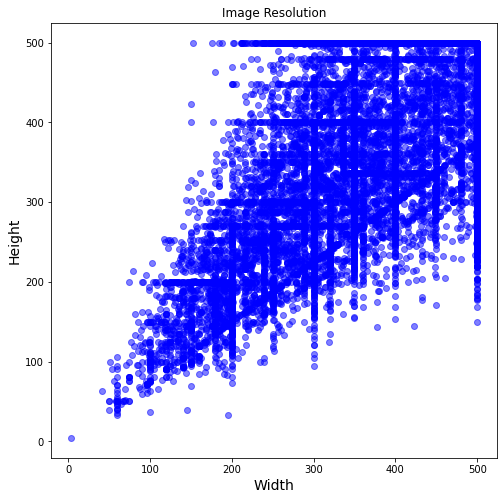

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(width, height, color='blue', alpha=0.5,  picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)

In [ ]:
print("The mean width is " ,np.mean(width))
print("The mean height is " ,np.mean(height))
print("The median width is " ,np.median(width))
print("The median height is " ,np.median(height))

The mean width is  404.4353576901363
The mean height is  360.9447939349948
The median width is  448.0
The median height is  375.0


In [ ]:
print('total training cats images:', len(train_cat_names))
print('total training dogs images:', len(train_dog_names))
print('total validation cats images:', len(validation_cat_names))
print('total validation dogs images:', len(validation_dog_names))
print('total evaluation cats images:', len(evaluate_cat_names))
print('total evaluation dogs images:', len(evaluate_dog_names))

total training cats images: 11249
total training dogs images: 11249
total validation cats images: 1150
total validation dogs images: 1150
total evaluation cats images: 100
total evaluation dogs images: 100


Outputs 8 different images of cats and dogs each time it is run

In [ ]:
%matplotlib inline

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

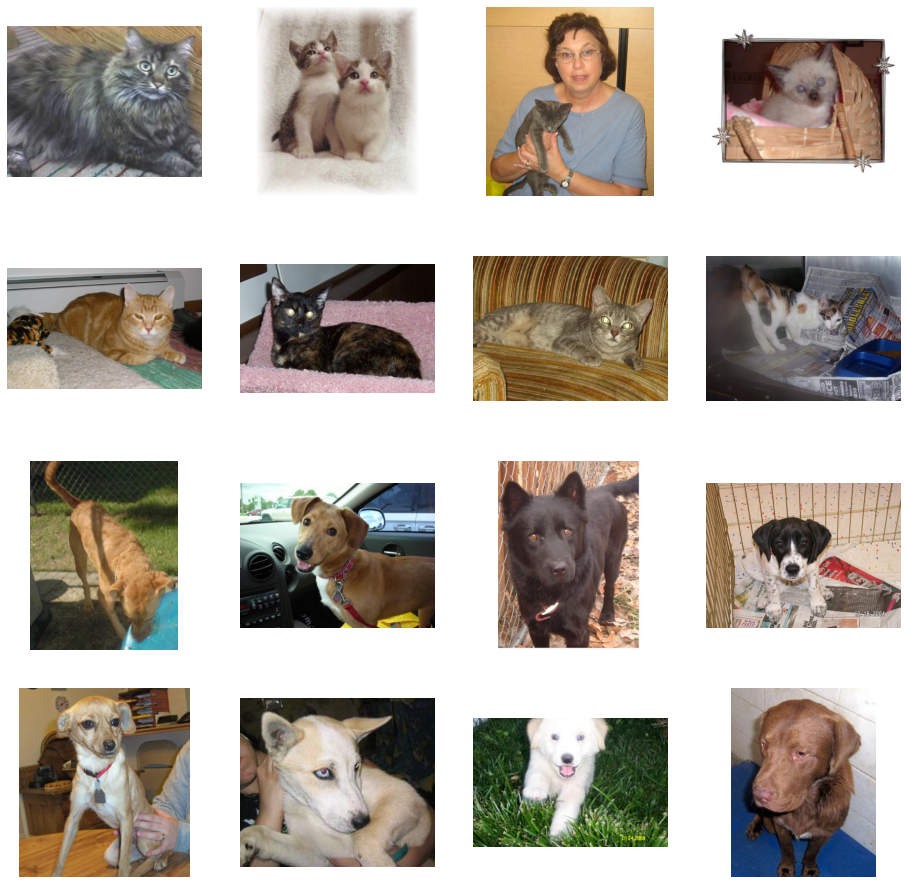

In [ ]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_names[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

Defining, compiling the model and defining the checkpoints

In [ ]:
model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(224, 224, 3),name='InputLayer',
    kernel_initializer = tf.keras.initializers.HeUniform()),
    tf.keras.layers.BatchNormalization(name = 'BatchNorm1'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),name = 'pooling1'),
    
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3),padding='same',name = 'Conv1',
    kernel_initializer = tf.keras.initializers.HeUniform(), 
    kernel_regularizer = tf.keras.regularizers.l2(l2=0.001)),
    tf.keras.layers.BatchNormalization(name = 'BatchNorm2'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),name = 'pooling2'),
    
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3),padding='same',name = 'Conv2', 
    kernel_initializer = tf.keras.initializers.HeUniform(),
    kernel_regularizer = tf.keras.regularizers.l2(l2=0.001)),
    tf.keras.layers.BatchNormalization(name = 'BatchNorm3'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),name = 'pooling3'),
    
    # The fourth convolution
    tf.keras.layers.Conv2D(256, (3,3),padding='same',name = 'Conv3',
    kernel_initializer = tf.keras.initializers.HeUniform(),
    kernel_regularizer = tf.keras.regularizers.l2(l2=0.00005)),
    tf.keras.layers.BatchNormalization(name = 'BatchNorm4'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),name = 'pooling4'),
    
    # Flatten the results to feed into a DNN
    
    tf.keras.layers.Flatten(),
    # 32 neuron hidden layer
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy',
              optimizer=Adam(amsgrad=True),
              metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('./model{epoch:08d}.h5',save_best_only=True, 
                                             save_weights_only=False,mode='auto',monitor='val_accuracy',
                                             verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,verbose=1,
                              patience=3, min_lr=0.0005)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (Conv2D)          (None, 222, 222, 32)      896       
_________________________________________________________________
BatchNorm1 (BatchNormalizati (None, 222, 222, 32)      128       
_________________________________________________________________
activation_4 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
pooling1 (MaxPooling2D)      (None, 111, 111, 32)      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 111, 111, 64)      18496     
_________________________________________________________________
BatchNorm2 (BatchNormalizati (None, 111, 111, 64)      256       
_________________________________________________________________
activation_5 (Activation)    (None, 111, 111, 64)     

In [ ]:
from PIL import ImageFont
font = ImageFont.truetype("../input/arialttf-font/arial.ttf", 32)

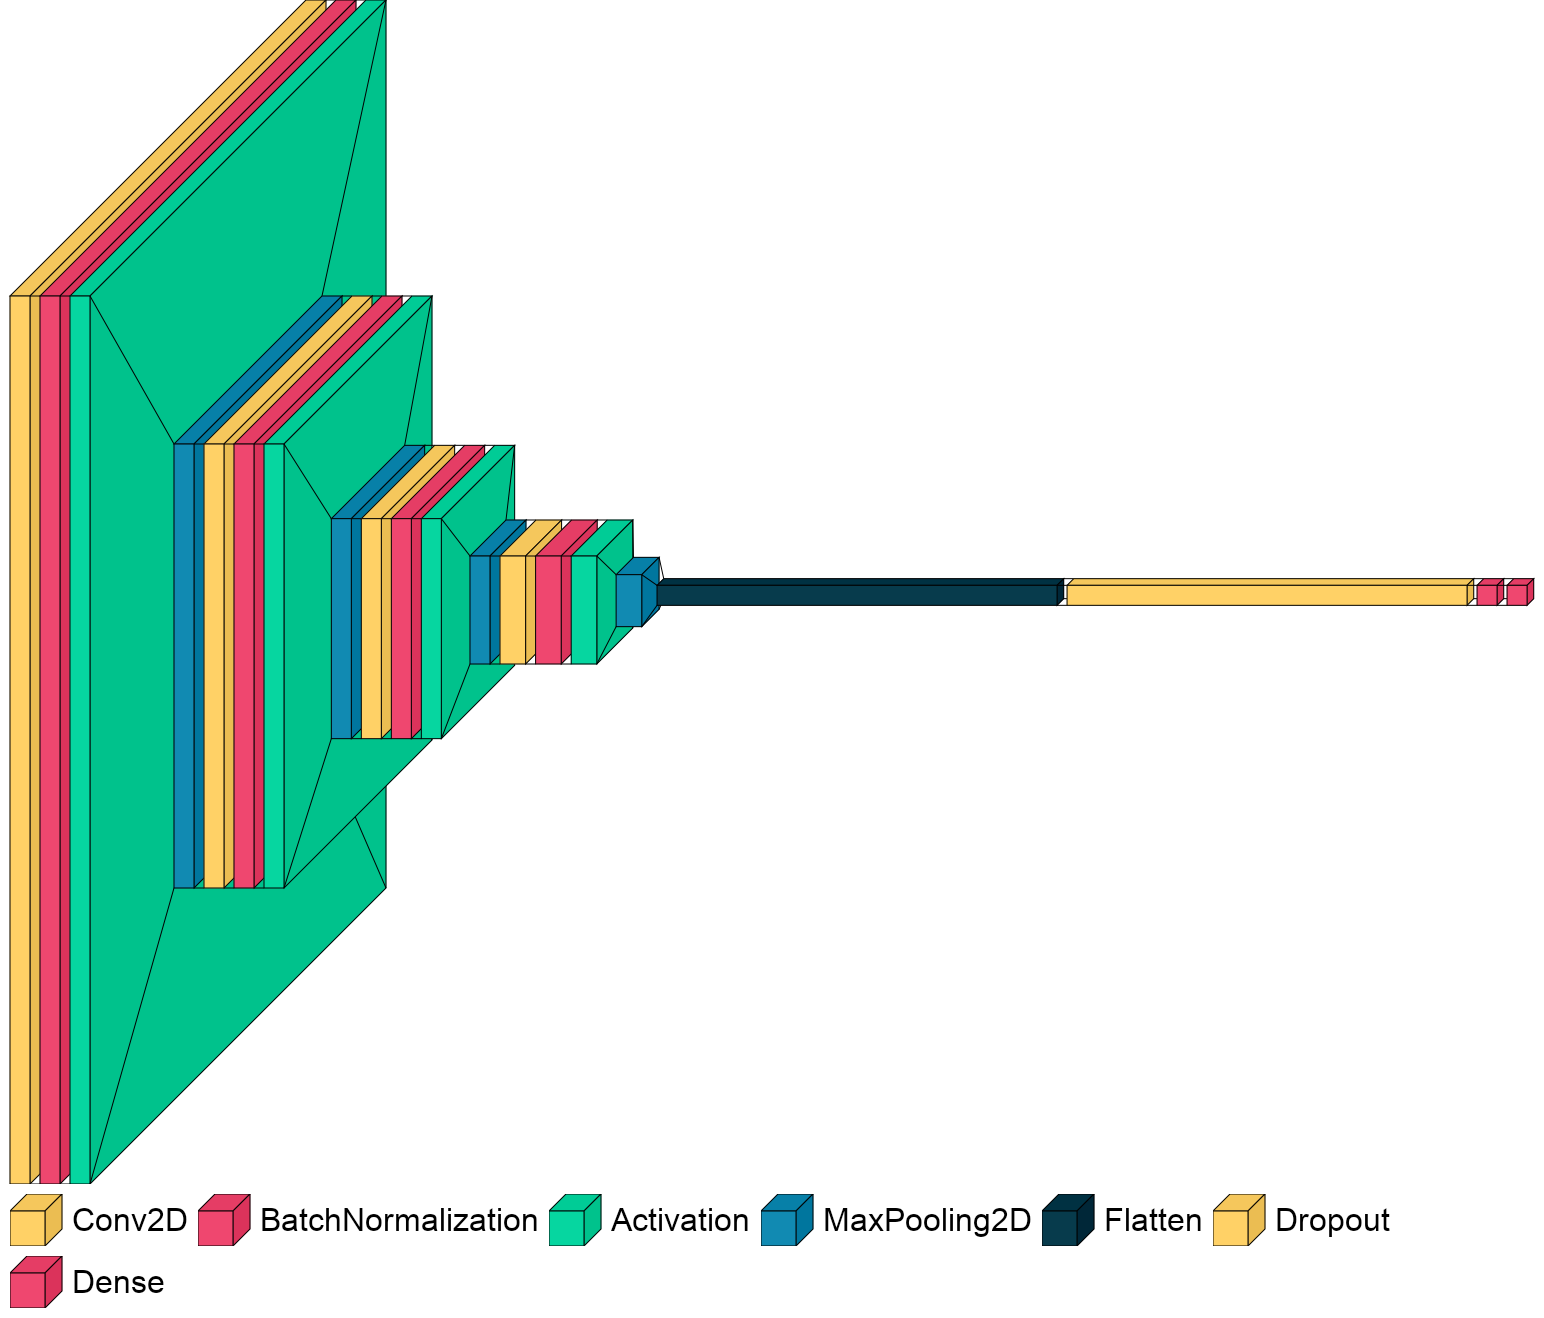

In [ ]:
visualkeras.layered_view(model, legend=True,font=font)

Creating Pipeling for flowing of data from directory to the model for training

In [ ]:
targetsize=(224,224)
train_datagen = ImageDataGenerator(
      rescale=1./255,rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 256 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './cats-v-dogs/training/',  # This is the source directory for training images
        target_size=(targetsize),  
        batch_size=256,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


validation_generator = validation_datagen.flow_from_directory(
        './cats-v-dogs/testing',  # This is the source directory for validation images
        target_size=(targetsize),  
        batch_size=512,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


testing_datagen=ImageDataGenerator(rescale=1./255)
testing_generator = testing_datagen.flow_from_directory(
        './cats-v-dogs/evaluate',  # This is the source directory for evaluation images
        target_size=(targetsize),  
        batch_size=32,class_mode='binary')


Found 22498 images belonging to 2 classes.
Found 2300 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Label Map for cats and dogs

In [ ]:
label_map = (train_generator.class_indices)
print(label_map)

{'cats': 0, 'dogs': 1}


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=(22498/256) ,  # 22498 images = (256)batch_size * steps
      epochs=60,
      validation_data=validation_generator,
      validation_steps=(2300/512) ,  # 2300 images = (512)batch_size * steps
      verbose=1,callbacks=[checkpoint,reduce_lr])

Epoch 1/60
87/87 [==============================] - 325s 4s/step - loss: 1.1667 - accuracy: 0.5783 - val_loss: 1.0506 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to ./model00000001.h5
Epoch 2/60
87/87 [==============================] - 319s 4s/step - loss: 0.9034 - accuracy: 0.6416 - val_loss: 1.0332 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.50000
Epoch 3/60
87/87 [==============================] - 322s 4s/step - loss: 0.7869 - accuracy: 0.7041 - val_loss: 1.1996 - val_accuracy: 0.5017

Epoch 00003: val_accuracy improved from 0.50000 to 0.50174, saving model to ./model00000003.h5
Epoch 4/60
87/87 [==============================] - 322s 4s/step - loss: 0.7219 - accuracy: 0.7280 - val_loss: 0.9013 - val_accuracy: 0.5800

Epoch 00004: val_accuracy improved from 0.50174 to 0.58000, saving model to ./model00000004.h5
Epoch 5/60
87/87 [==============================] - 318s 4s/step - loss: 0.6592 - accuracy: 0.7

Evaluating the model on random unseen data and achieving 96% accuracy

In [ ]:
historyevaluate=model.evaluate(testing_generator)

7/7 [==============================] - 1s 106ms/step - loss: 0.1825 - accuracy: 0.9600


In [ ]:
print("Test Loss: {:.5f}".format(historyevaluate[0]))
print("Test Accuracy: {:.2f}%".format(historyevaluate[1] * 100))

Test Loss: 0.18247
Test Accuracy: 96.00%


Plotting the Accuracy and Loss Graph

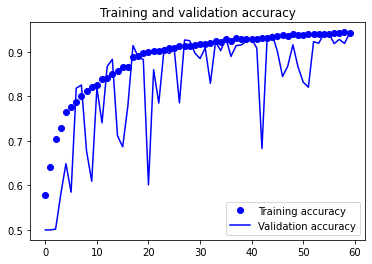

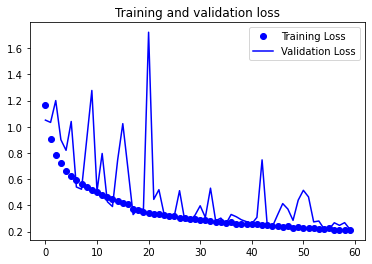

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Visualising how image transforms in different layers

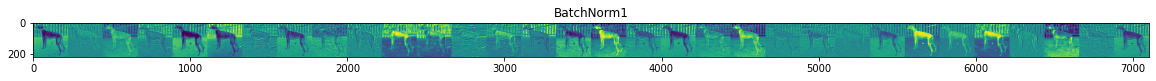

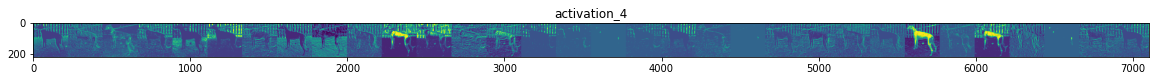

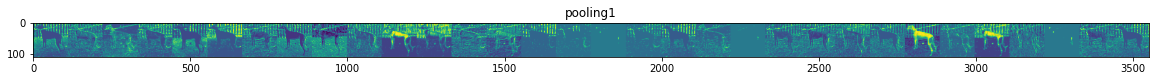

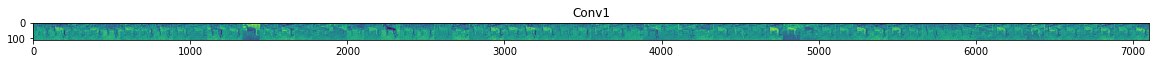

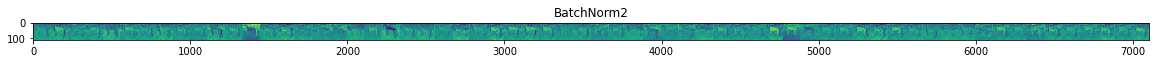

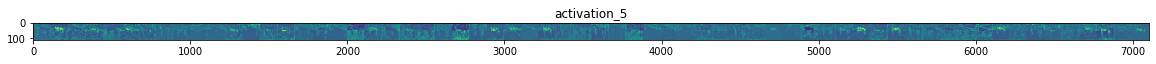

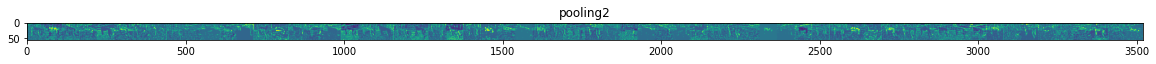

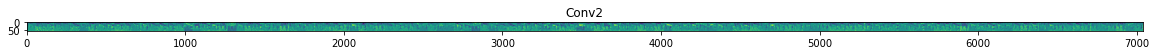

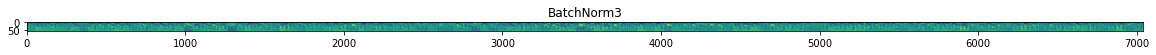

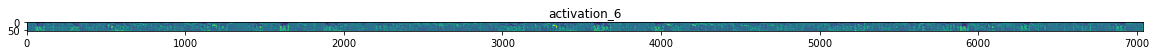

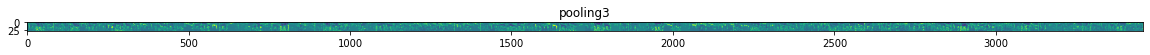

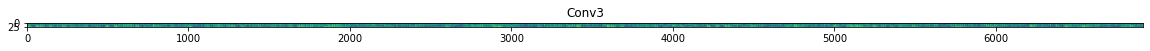

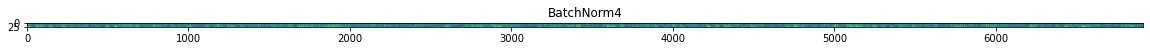

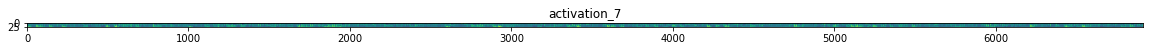

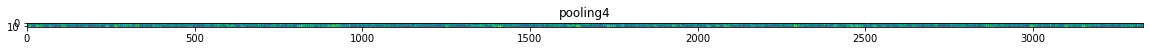

In [ ]:
successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_names]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_names]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(targetsize))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (224, 224, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 224, 224, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')